# Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.stats import skew, kurtosis
from sklearn.cluster import AgglomerativeClustering

# GLOBAL VARIABLES

# time horizon in years
T = 20  

# number of time steps
N = int(T * 252 * 7)  

# change remige's lenght
l_regime = int(0.5  * 252 * 7)

# time interval
dt = T / N

# GBM parameters
gbm_par = np.array(
    [[0.02, 0.2], #mu,sigma bull-regime
    [-0.02, 0.3]]) #mu,sigma bear-regime

# array of all the timesteps
timestep = np.linspace(0, T, N)

In [2]:
def data_par(h_1, h_2):
    '''
    Given the hyper parameters h_1 and h_2 it returns the number of sub-sequences M and the effective number of log-returns that
    are involved in the analysis N_prime.
    
    '''
    
    # check the number of possible sub sequences M
    i = 0
    # N - 2 (-1:from price to log-return and -1:becuase the last index is lenght of the array -1)
    while ((h_1 - h_2) * i + h_1) <= (N-2):
        i = i + 1

    # IMPORTANT parameters
    M = i 
    N_prime = (h_1 - h_2) * (M-1) + h_1 + 1
    
    return N_prime, M

h_1 = 35
h_2 = 28
N_prime, M = data_par(h_1, h_2)
t = timestep[: N_prime + 1]

print(f"price values not included in the analysis = {len(timestep) - len(t)}")

price values not included in the analysis = 5


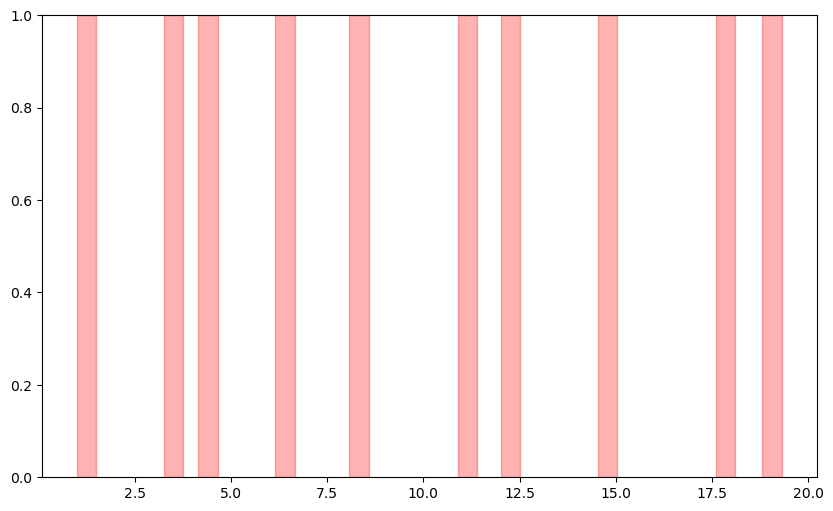

In [3]:
def generate_regimes(N_prime):
    '''
    It generates randomly 10 different time interval of the same same lenght.
    
    '''

    A = np.arange(0, N_prime+1)

    # Parametri delle sottosequenze
    num_subsequences = 10
    subseq_length = l_regime 

    # Set per memorizzare gli indici di partenza usati
    used_indices = set()

    # Funzione per generare un indice di partenza valido
    def generate_start_index(random_state=17):
        np.random.seed(random_state)
        while True:
            # Genera un indice di partenza casuale
            start_index = np.random.randint(0, len(A) - subseq_length - 1)
            # Controlla se l'indice di partenza e l'indice finale (con buffer di 1) sono validi
            if all((start_index + i) not in used_indices for i in range(subseq_length + 1)):
                for i in range(subseq_length + 1):
                    used_indices.add(start_index + i)
                return start_index

    # Generazione delle sottosequenze random non sovrapposte con almeno un elemento di distanza
    subsequences = []
    for _ in range(num_subsequences):
        start_index = generate_start_index()
        subsequences.append(A[start_index:start_index + subseq_length])

    subsequences = np.sort(np.array(subsequences), axis=0)
    
    # label for the log-returns
    B = np.zeros(N_prime)
    for sub in subsequences:
        B[sub[0]: sub[-1]] = 1    
    B = B.astype(int)

    # label for prices
    C = np.zeros(N_prime+1)
    for sub in subsequences:
        C[sub] = 1    
    C = C.astype(int)


    
    return subsequences, B, C

subsequences, theo_labels, labels_prices = generate_regimes(N_prime)

# plot of the regimes
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.axvspan(timestep[subsequences[i][0]], timestep[subsequences[i][-1]], color='red', alpha=0.3)
plt.show()

mean_path = 1.5904336169888507 
std_path = 0.8746807632129775


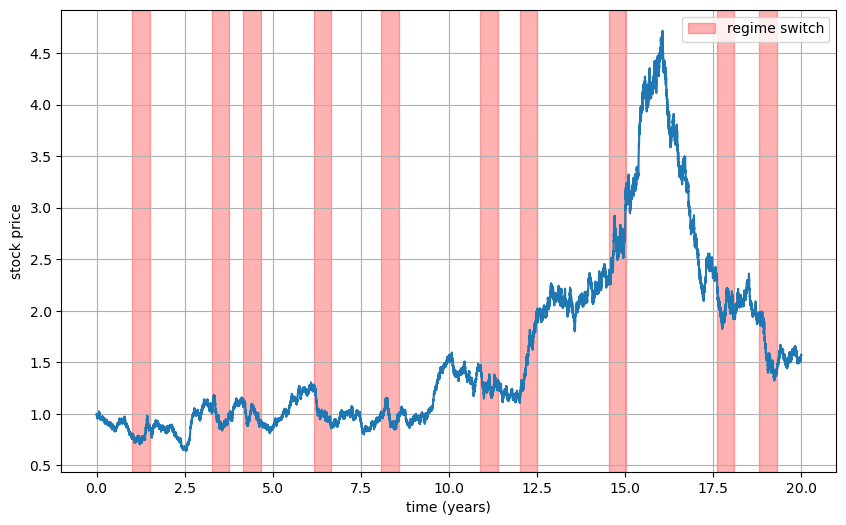

In [4]:
def gbm(S0, mu, sigma, n, dt):
    """
    Simulates a Geometric Brownian Motion (GBM).

    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift coefficient
    sigma (float): Volatility coefficient
    T (float): Time horizon
    n (int): Number of time steps

    Returns:
    np.ndarray: Simulated stock prices

    """
    t = np.arange(1, n) * dt
    W = np.random.standard_normal(size=n-1) 
    W = np.cumsum(W) * np.sqrt(dt) # cumulative sum to simulate the Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = np.zeros(n)
    S[0] = S0
    S[1:] = S0 * np.exp(X)
    return S

def gbm_path(N_prime, C, t):
    
#     np.random.seed(17)
    '''
    It simulates the entire path of a GBM with regimes switch.
    
    '''
    # array of prices
    s = np.zeros(N_prime + 1)
    # initial stock price
    s[0] = 1
    s_0 = s[0]
    start_index = 0
    stop_index = 1

    for k in range(1, N_prime+1):
        if k == N_prime:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]), dt)

        elif C[k] == C[k+1]:
            stop_index = k+1

        else:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]), dt)
            #updates
            start_index = k
            s_0 = s[k]
            stop_index = k + 1
            
    return s

# to ensure reproducibility
np.random.seed(15)

# relevant time series
prices = gbm_path(N_prime, labels_prices, t)  
log_returns = np.diff(np.log(prices))

print(f'mean_path = {np.mean(prices)} \nstd_path = {np.std(prices)}')

# plot price path
plt.figure(figsize=(10, 6))
plt.plot(t,prices)
for i in range(10):
    if i == 0:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3, label='regime switch')
        
    else:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3)
        
    
#plt.title("Geometric Brownian Motion Simulation")
plt.xlabel("time (years)")
plt.ylabel("stock price")
plt.grid()
plt.legend()
plt.show()
plt.show()

In [5]:
def lift_function(h_1, h_2, log_returns, M):
    '''
    It returns a matrix (and the sorted version) in which the rows are the subsequences.
    
    '''

    # creation of the sub-sequences
    lift_matrix = np.ndarray((M, h_1 + 1))

    for j in range(0, M):
        lift_matrix[j] = log_returns[(h_1 - h_2) * j : (h_1 - h_2) * j + h_1 + 1]

    sorted_lift_matrix = np.sort(lift_matrix)
    return lift_matrix, sorted_lift_matrix

lift_matrix, sorted_lift_matrix = lift_function(h_1, h_2, log_returns, M)
print(f'number of sub sequences = {M}')

number of sub sequences = 5035


In [7]:
# costruction of a suitable dataset
from sklearn.preprocessing import StandardScaler

# from each empiracal cdf we take the firsts q moments (a vector of dim. q for each empirical cdf)
q = 4

# Function to compute the k-th raw moment along a specified axis
def raw_moment_nd(values, k, axis=None):
    return np.mean(values**k, axis=axis)


# compute raw moments along the specified axis (axis=None computes the raw moments over the entire array)
X_moments = np.array([raw_moment_nd(lift_matrix, k, axis=1) for k in range(1, q+1)]).T

# initialize the StandardScaler
scaler = StandardScaler()

# fit and transform the data
standardized_X_moments = scaler.fit_transform(X_moments)

# print the standardized data
print(np.mean(standardized_X_moments, axis=0))
print(np.std(standardized_X_moments, axis=0))

[-4.23362107e-18  1.91924155e-16 -5.64482809e-18 -1.97568983e-17]
[1. 1. 1. 1.]


## Hierarchical clustering 
kinds of linkage:

‘ward’ minimizes the variance of the clusters being merged.

‘average’ uses the average of the distances of each observation of the two sets.

‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.

‘single’ uses the minimum of the distances between all observations of the two sets.

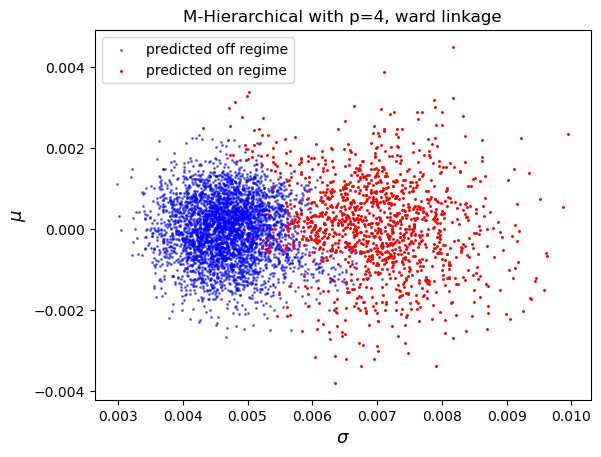

In [17]:
linkage = 'ward'

clustering = AgglomerativeClustering(linkage=linkage).fit(standardized_X_moments)

# off-regime->lower variance
off_regime_index = 0 
# on-regime->higher variance
on_regime_index = 1 
# check regime
if (clustering.labels_ == 1).sum() > (clustering.labels_ == 0).sum():
    
    off_regime_index = 1
    on_regime_index = 0


# scatter plot of empirical cdf
point_size = 5
plt.scatter(
    np.std(lift_matrix[clustering.labels_ == off_regime_index], axis=1),
    np.mean(lift_matrix[clustering.labels_ == off_regime_index], axis=1),
    marker='.', color='b', alpha=0.5, s=point_size, label='predicted off regime')
plt.scatter(
    np.std(lift_matrix[clustering.labels_ == on_regime_index], axis=1),
    np.mean(lift_matrix[clustering.labels_ == on_regime_index], axis=1),  
    marker='.', color='r', alpha=1, s=point_size, label='predicted on regime')

plt.legend()
plt.xlabel(f'$\sigma$', size=13)
plt.ylabel(f'$\mu$', size=13)
plt.title(f'M-Hierarchical with p={q}, {linkage} linkage')
plt.legend()
# PAY ATTENTION
# plt.savefig(f'figure/{q}_m_hierarchical_h_35_28_gbm_15_{linkage}.pdf', bbox_inches='tight')
plt.show()

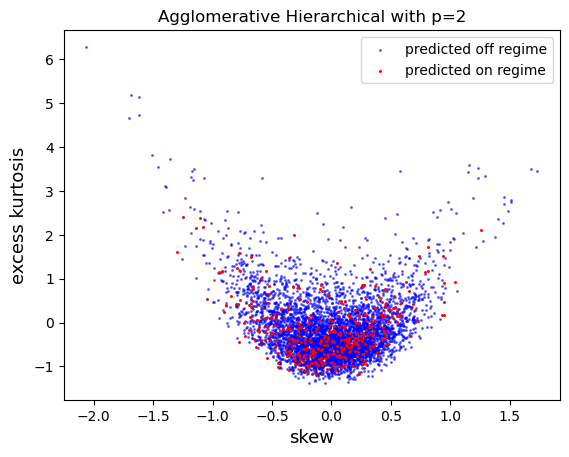

In [86]:
# scatter plot of empirical cdf
point_size = 5
plt.scatter(
    skew(lift_matrix[clustering.labels_ == off_regime_index], axis=1),
    kurtosis(lift_matrix[clustering.labels_ == off_regime_index], axis=1),
    marker='.', color='b', alpha=0.5, s=point_size, label='predicted off regime')
plt.scatter(
    skew(lift_matrix[clustering.labels_ == on_regime_index], axis=1),
    kurtosis(lift_matrix[clustering.labels_ == on_regime_index], axis=1),  
    marker='.', color='r', alpha=1, s=point_size, label='predicted on regime')

plt.legend()
plt.xlabel(f'skew', size=13)
plt.ylabel(f'excess kurtosis', size=13)
plt.title(f'Agglomerative Hierarchical with p={q}')
plt.legend()
plt.show()
plt.show()

## Accuracy scores

In [13]:
def opt_counter(kmeans, n, M, h_1, h_2):


    # Define the time indices for the sliding window
    time_indices = np.arange(n)[:, None] - (h_1 - h_2) * np.arange(M)[None, :]

    # Mask invalid indices
    valid_mask = (time_indices >= 0) & (time_indices <= h_1)

    # Use the valid_mask to filter time indices
    filtered_time_indices = time_indices * valid_mask

    # Create the labels array, repeated across all k for efficient processing
    labels_repeated = np.tile(kmeans.labels_, (n, 1))

    # Use the valid mask to apply the labels where indices are valid
    filtered_labels = np.where(valid_mask, labels_repeated, -1)

    # Count occurrences of each label
    r_counter_0 = np.sum(filtered_labels == 0, axis=1)
    r_counter_1 = np.sum(filtered_labels == 1, axis=1)

    # Combine the counts into a single array
    r_counter = np.stack((r_counter_0, r_counter_1), axis=1)
    
    # Initialize s_counter with the same shape as r_counter
    s_counter = np.zeros((n+1, 2))

    # Handle the first element
    s_counter[0] = r_counter[0]

    # Handle the last element
    s_counter[-1] = r_counter[-1]

    # For all other elements, sum the current and previous elements
    s_counter[1:-1] = r_counter[:-1] + r_counter[1:]

    
    return r_counter, s_counter


In [18]:
%%time
r_counter, s_counter = opt_counter(clustering, len(log_returns), M, h_1, h_2)

dec = 2
# regime-off accuracy score (ROFS)
ROFS = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])
print(f'ROFS = {round(ROFS, dec)}')

# regime-off accuracy score (ROFS)
RONS = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])
print(f'RONS = {round(RONS, dec)}')

# total accuracy (TA)
TA = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
print(f'TA = {round(TA, dec)}')

ROFS = 0.95
RONS = 0.87
TA = 0.93
Wall time: 2.53 s


# CLUSTERING VALIDATION

In [23]:
def clustering_validation(h_1 = 35, h_2 = 28, n_runs = 50):
    
    rofs = np.zeros(n_runs)
    rons = np.zeros(n_runs)
    ta = np.zeros(n_runs)
    iteration_times = np.zeros(n_runs)
    
    N_prime, M = data_par(h_1, h_2)
    t = timestep[: N_prime + 1]
    subs, theo_labels, price_labels = generate_regimes(N_prime)
    
    for j in range(n_runs): 
        
        # data preparation
        np.random.seed(j)
        log_returns = np.diff(np.log(gbm_path(N_prime, price_labels, t)))
        # start timing
        start = time.time()
        lift_matrix = lift_function(h_1, h_2, log_returns, M)[0]
        ### IMPORTANT ##
        q = 2
        # 
        X_moments = np.array([raw_moment_nd(lift_matrix, k, axis=1) for k in range(1, q+1)]).T
        # initialize the StandardScaler
        scaler = StandardScaler()
        # fit and transform the data
        standardized_X_moments = scaler.fit_transform(X_moments)

        ##### clustering
        linkage = 'ward'

        clustering = AgglomerativeClustering(linkage=linkage).fit(standardized_X_moments)

        # off-regime->lower variance
        off_regime_index = 0 
        # on-regime->higher variance
        on_regime_index = 1 
        # check regime
        if (clustering.labels_ == 1).sum() > (clustering.labels_ == 0).sum():

            off_regime_index = 1
            on_regime_index = 0

        # counter    
        r_counter = opt_counter(clustering, len(log_returns), M, h_1, h_2)[0]

        # regime-off accuracy score (ROFS)
        rofs[j] = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])

        # regime-off accuracy score (ROFS)
        rons[j] = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])

        # total accuracy (TA)
        ta[j] = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
        
        iteration_times[j] = time.time() - start

    return rofs, rons, ta, iteration_times

In [24]:
%%time
dec = 4
rofs, rons, ta, iteration_times = clustering_validation(h_1 = 35, h_2 = 28, n_runs = 50)
print(f"ROFS = {round(np.mean(rofs), dec)} -+ {round(np.std(rofs), dec)}")
print(f"RONS = {round(np.mean(rons), dec)} -+ {round(np.std(rons), dec)}")
print(f"TA = {round(np.mean(ta), dec)} -+ {round(np.std(ta), dec)}")
print(f"RUN TIME = {round(np.mean(iteration_times), dec)} -+ {round(np.std(iteration_times), dec)}")

ROFS = 0.943 -+ 0.1258
RONS = 0.7666 -+ 0.1471
TA = 0.8989 -+ 0.1205
RUN TIME = 3.2441 -+ 0.0637
Wall time: 2min 42s


In [25]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# p=4, m-hierarchical, h=h_1,h_2, path = gbm, n_trials=50, linkage=ward
# name of the file = 'numerical_results/4_m_hierarchical_h_35_28_gbm_n_50_ward.txt'

df.to_csv('numerical_results/2_m_hierarchical_h_35_28_gbm_n_50_ward.txt', index=False)

In [26]:
# read the results
df = pd.read_csv('numerical_results/4_m_hierarchical_h_35_28_gbm_n_50_ward.txt')

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
iteration_times = df['RUNTIME'].values

print(f"ROFS = {round(np.mean(rofs), 2)} -+ {round(np.std(rofs), 2)}")
print(f"RONS = {round(np.mean(rons), 2)} -+ {round(np.std(rons), 2)}")
print(f"TA = {round(np.mean(ta), 2)} -+ {round(np.std(ta), 2)}")
print(f"RUN TIME = {round(np.mean(iteration_times), 2)} -+ {round(np.std(iteration_times), 2)}")

ROFS = 0.98 -+ 0.01
RONS = 0.77 -+ 0.12
TA = 0.93 -+ 0.02
RUN TIME = 3.33 -+ 0.04
